# [Hw03] Feature Selection
Jeong Ji Hoon 2016010980

### Import packages

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import combinations

%matplotlib inline

### Constants

In [60]:
NUM_FEATURE = 4 # Number of Features in each sample

## 0. Load the Iris dataset using Pandas

In [61]:
#Dataset Download
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',header=None)
dataset = df.values

#Iris name to integer codes
iris_names = np.unique(dataset[:,NUM_FEATURE])
for i,name in enumerate(iris_names):
    dataset[np.where(dataset[:,NUM_FEATURE] == name),NUM_FEATURE] = i

X = dataset[:,:NUM_FEATURE].astype(float)
y = dataset[:,NUM_FEATURE].astype(int)

featureLabels = ['sepal length', 'sepal width', 'petal length', 'petal width']

print('[System] Data import success')

[System] Data import success


## 1. Spliting Data into Train/Test Sets + Standardization

In [62]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

## 4개의 feature가 관여되기에 전부 Standardization을 진행
# Standardization
clf_std = StandardScaler()
clf_std.fit(X_train)
X_train_std = clf_std.transform(X_train)
X_test_std = clf_std.transform(X_test)

## 2. Applying SBS & feature_importance_ method

### 2-1. Define SBS Class
강의자료 코드. 코드 이해를 위해 주석을 추가해둠.
constructor에서 estimator를 clone하지 않고 그냥 받아옴.
(이후 코드에서 이 부분을 반영함)

In [63]:
class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,test_size=0.25, random_state=1):
        self.scoring = scoring # 어떤 방식으로 clf의 performance를 체크할지.
        self.estimator = estimator
        self.k_features = k_features # 남길 feature의 수. = 사용할 feature의 수. k_features 개 만큼 남을때까지 feature를 지움.
        self.test_size = test_size
        self.random_state = random_state
    def fit(self, X, y):
        # 들어온 데이터 셋을 다시 train과 test set으로 나누고
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        # 데이터 셋의 feature 수를 dim에 저장.
        dim = X_train.shape[1]
        # 하나의 feature만 있는 clf의 결과를 self.score_ 값에 저장.
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,X_test, y_test, self.indices_)
        self.scores_ = [score]
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        return X[:, self.indices_]
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        # indices에 넣은 feature 들로만 fit을 진행해서 score 값을 얻어낸다.
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

### 2-2. Random Forest Classifier에 대해서

In [64]:
# Classifier 자체는 HW2의 파라미터를 그대로 사용.
clf = RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)

#### 2-2-1. Sequential Backward Selection을 적용.

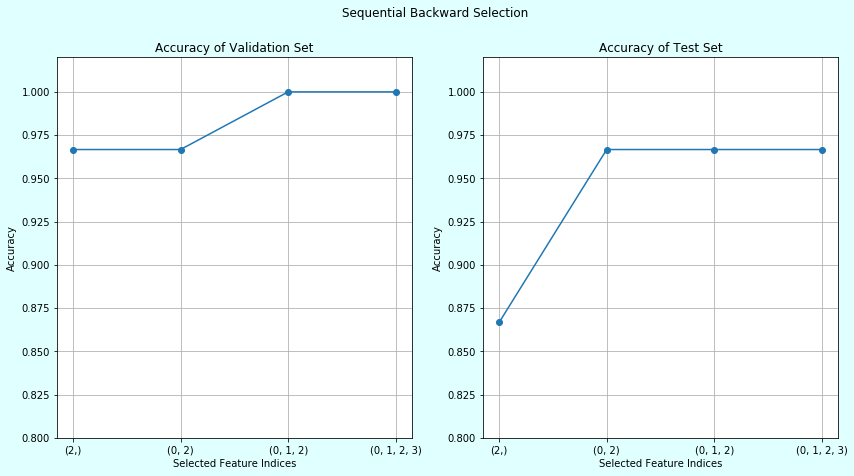

In [65]:
# Feature Selection 1 : Sequential Backward Selection
fs1 = SBS(clf, k_features = 1, scoring=accuracy_score, test_size=0.25, random_state=1)
fs1.fit(X_train_std, y_train)

# Validation Set Result
k_feat = [len(k) for k in fs1.subsets_]

fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Sequential Backward Selection')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Validation Set')
ax[0].plot(k_feat, fs1.scores_, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(fs1.subsets_)
ax[0].grid()

# Testing Set Result
result = []
for sub in fs1.subsets_:
    clf_test = RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)
    clf_test.fit(X_train_std[:,sub],y_train)
    result.append(accuracy_score(y_test,clf_test.predict(X_test_std[:,sub])))

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(fs1.subsets_)
ax[1].grid()

#### Result
- index 3 > index 1 > index 0 의 순으로 feature를 제거했다. 
- test set의 경우 feature 수가 두 개가 되어도 feature 전부를 사용한 경우에 비해 performance가 줄어들지 않았다.
- 이는 적은 feature로도 성공적으로 classification이 가능하다는 것을 보여주며 computational resource를 줄여줄 수 있다.
- Training에 한번도 사용되지 않은 Test set이라 그런지 validation set처럼 100% performance를 보여주지는 못했다.

#### 2-2-1. feature_importances_ Method를 적용.

Text(0,0.5,'Importance')

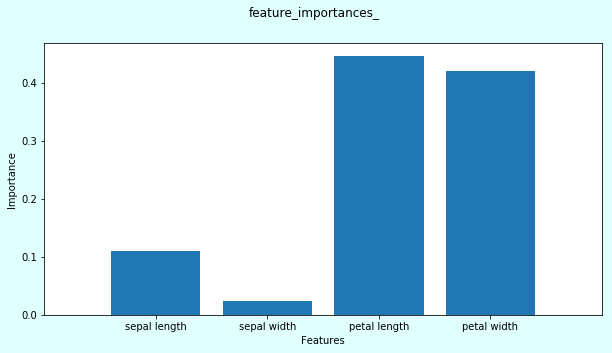

In [66]:
# 먼저 각 feature들의 importance를 구한다.
fs2 = RandomForestClassifier(n_estimators=500,random_state=1)
fs2.fit(X_train_std, y_train)
importance = fs2.feature_importances_

fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('feature_importances_')

ax = fig.add_subplot(111)
ax.bar(range(X_train_std.shape[1]), importance, align='center')
ax.set_xlim(-1, X_train.shape[1])
ax.set_xlabel('Features')
ax.set_xticklabels(featureLabels)
ax.set_xticks(range(X_train.shape[1]))

ax.set_ylabel('Importance')

- petal length > petal width > sepal length > sepal width 순으로 feature가 classification에 중요하다는 것을 알게 되었다.
- 이를 기반으로 중요도가 낮은 feature를 하나씩 빼가며 k=4부터 k=1까지 feature subset을 만들 것이다.

In [67]:
# 위의 결과를 토대로 k=4 부터 importance가 가장 낮은 feature들을 빼면서 SBS의 subsets_와 같은 변수를 만든다.
# 이 변수를 통해서 k=4부터 k=1까지 subset을 만들고 이를 training 통해 performance를 확인.
subset = []
i_importance = np.argsort(importance)[::-1]
for i in range(4,0,-1):
    subset.append(np.sort(tuple(i_importance[:i])))

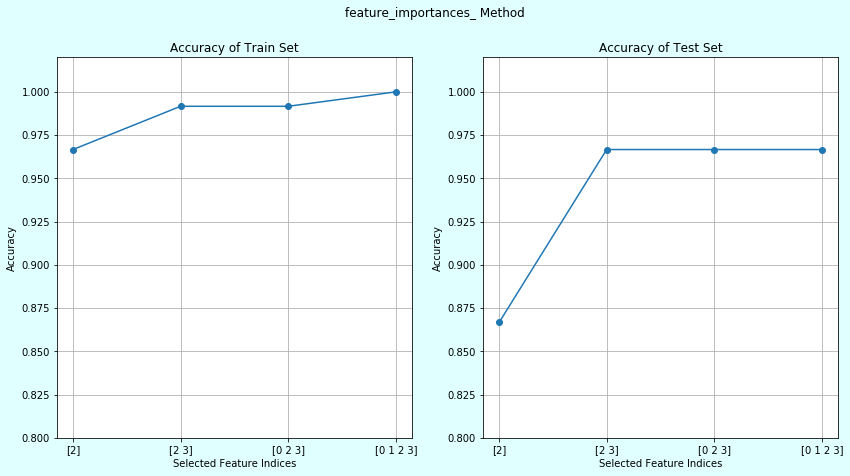

In [68]:
# Performance
result_train = []
result_test = []

for sub in subset:
    clf = RandomForestClassifier(criterion='gini',n_estimators=25,random_state=1,n_jobs=2)
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('feature_importances_ Method')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.8, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.8, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

#### Result
- 앞서 사용한 SBS와는 다르게 feature subset이 선택되었다. 
- 그러나 단일 feature로 구분을 하기에는 petal length가 가장 좋은 feature임이 나타났다.
- 현재 전체 데이터 사이즈가 150개 밖에 되지 않는다. 따라서 feature selection 을 할때 40개/Class * 3Class 샘플만 사용이 된다.이런 경우 score 값이 각 사용한 feature 조건 별로 유사하게 나올 가능성이 있다.그런데 SBS.fit 내에서 np.argmax() 함수는 두 개 이상의 조건에서 max값이 나오면 무조건 앞의 조건을 선택한다.때문에 feature index가 더 작은 숫자라면(더 앞에 있다면) 뒤 조건에 비해서 선택될 가능성이 높기에 수정이 필요할 수도 있다. 다행히 feature_importance_ method의 경우는 features subset으로 고르는데 필요한 점수가(importance) SBS의 경우(accuracy)처럼 단순하게 나오지 않기에 이런 문제는 없을 듯 하다.

## 3. Applying SBS & feature_importance_ method to Other Classifier

### 3-1. Logistic Regression

#### 3-1-1. Define Class (from HW02)

In [69]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value in each epoch.

    """

    def __init__(self, eta=0.05, n_iter=100, random_state=1, batch_size=-1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.batch_size = batch_size

    def fit(self, X, y):
        """ Fit training data.
        batch size를 기준으로 입력된 X 값을 batch size로 나눠서 학습을 시킴.
        X 사이즈가 batch size로 딱 나누어 떨어지지 않는 경우,
         맨 마지막 남는 데이터는 batch size 보다 크기가 작아도 그대로 학습을 진행.
         ex) X.shape[0] = 150, batch_size = 100
         epoch1-1 : X[0:100]
         epoch1-2 : X[100:150]
         epoch2-1 : X[0:100]
         epoch2-2 : X[100:150]
       대신 batch size로 -1을 넣는 경우 그냥 batch Gradient Descent 방식을 사용.
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        if self.batch_size == -1: # Batch Gradient
            self.batch_size = X.shape[0]
        for i in range(self.n_iter):
            if X.shape[0] % self.batch_size == 0:  # training set 크기가 batch_size로 딱 나눠지는 경우
                batch_n_iter = int(X.shape[0] / self.batch_size)  # batch를 돌려아 하는 횟수.
                # 딱 나눠지는 경우에는 배치 사이즈 그대로 train을 시킴.
                for b in range(batch_n_iter):
                    smallX = X[self.batch_size * b : self.batch_size * (b + 1), :]
                    smally = y[self.batch_size * b : self.batch_size * (b + 1)]
                    net_input = self.net_input(smallX)
                    output = self.activation(net_input)
                    errors = (smally - output)
                    self.w_[1:] += self.eta * smallX.T.dot(errors)
                    self.w_[0] += self.eta * errors.sum()
                    cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                    self.cost_.append(cost)

            else:  # training set 크기가 batchsize로 딱 나눠지지 않는 경우
                batch_n_iter = int(np.floor(X.shape[0] / self.batch_size))
                # 배치 사이즈 그대로 train을 시키고,
                for b in range(batch_n_iter):
                    smallX = X[self.batch_size * b : self.batch_size * (b + 1), :]
                    smally = y[self.batch_size * b : self.batch_size * (b + 1)]
                    net_input = self.net_input(smallX)
                    output = self.activation(net_input)
                    errors = (smally - output)
                    self.w_[1:] += self.eta * smallX.T.dot(errors)
                    self.w_[0] += self.eta * errors.sum()
                    cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                    self.cost_.append(cost)
                # 나머지를 전부 넣어줌.
                smallX = X[self.batch_size * batch_n_iter :, :]
                smally = y[self.batch_size * batch_n_iter :]
                net_input = self.net_input(smallX)
                output = self.activation(net_input)
                errors = (smally - output)
                self.w_[1:] += self.eta * smallX.T.dot(errors)
                self.w_[0] += self.eta * errors.sum()
                cost = -smally.dot(np.log(output)) - ((1 - smally).dot(np.log(1 - output)))
                self.cost_.append(cost)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
        
class LogisticRegressionGD_3C(object):
    """Class 3개인 데이터를 위한 classifier.
    3개의 LogisticRegressionGD Class를 만든뒤 One Versus All 방식으로 Class를 분류."""
    def __init__(self, eta=0.001, n_iter=1000, random_state=1, batch_size = -1):
        self.clf = [LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size = batch_size),
                    LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size = batch_size),
                    LogisticRegressionGD(eta=eta, n_iter=n_iter, random_state=random_state, batch_size = batch_size)]

    def fit(self, X, y):
        # y값이 -1과 1이 아니라 0,1,2 의 세 숫자로 구성되기에 각 classifier에 맞는 형태로 변형시켜주어야 함.
        y_3C = 0 * np.ones([y.size, 3]) # sample 수 X 3 크기로 전부 0인 array를 만들고,
        for s, c in enumerate(y): # 모든 sample에 대해서
            y_3C[s, c] = 1  # index y에 해당하는 값만 1로 바꿔줌.
            # 이렇게 하면 Class0인 경우 [1,-1,-1], Class1인 경우 [-1,1,-1] 형태의 array가 만들어짐.

        for c in range(3):
            self.clf[c].fit(X,y_3C[:,c])
        return self

    def predict(self, X):
        result = np.zeros([X.shape[0],3])
        for c in range(3):
            result[:,c] = self.clf[c].net_input(X) # predict를 바로 하는 것이 아니라 net_input 값만 받아둠.
        return np.argmax(result, axis=1)

#### 3-1-2. SBS

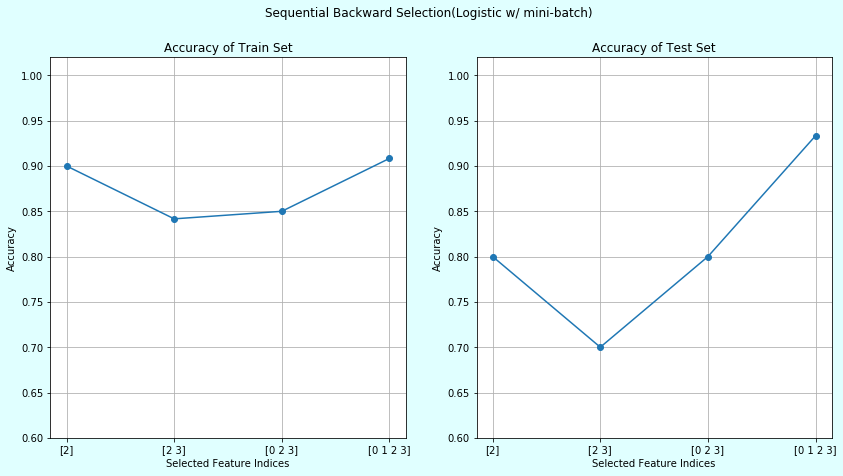

In [70]:
# Performance
result_train = []
result_test = []

eta = 0.01
batch_size = 4

for sub in fs1.subsets_:
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Sequential Backward Selection(Logistic w/ mini-batch)')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.6, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.6, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

- 생각보다 performance가 낮게 나와 y 축을 조정해주어야 했다.

#### 3-1-3.  feature_importances_ Method

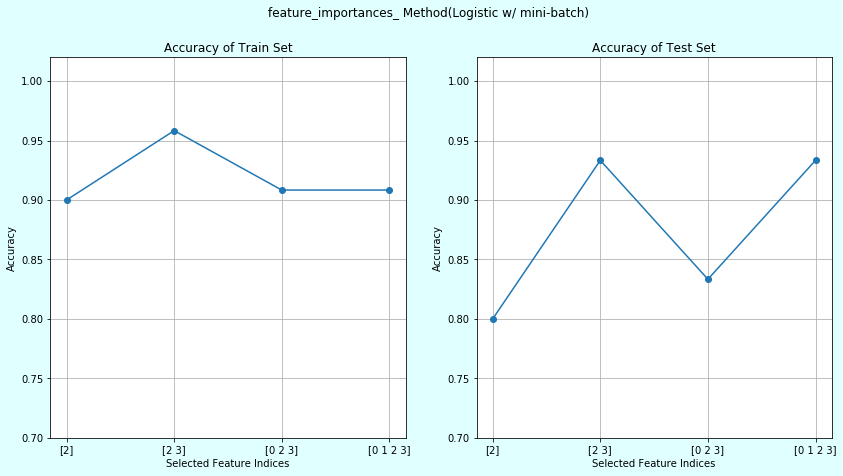

In [71]:
# Performance
result_train = []
result_test = []

eta = 0.01
batch_size = 4

for sub in subset:
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('feature_importances_ Method(Logistic w/ mini-batch)')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.7, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.7, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

#### Result
- SBS, feature_importances_ 방법 모두 적은 feature set에 대해서는 정확도가 낮게 나왔다.
- 이는 features selection method에 사용한 classifier(Random Forest)와 실제로 performance를 본 classifier가 달라서 그런 것이 아닌가 생각된다.
- 하지만 SBS보다는 feature_importances_ 방법에서 나눈 k=1부터 4까지의 subset들은 비교적 높은 결과를 보여주었다.

### 3-2. SVM

#### 3-2-1. SBS

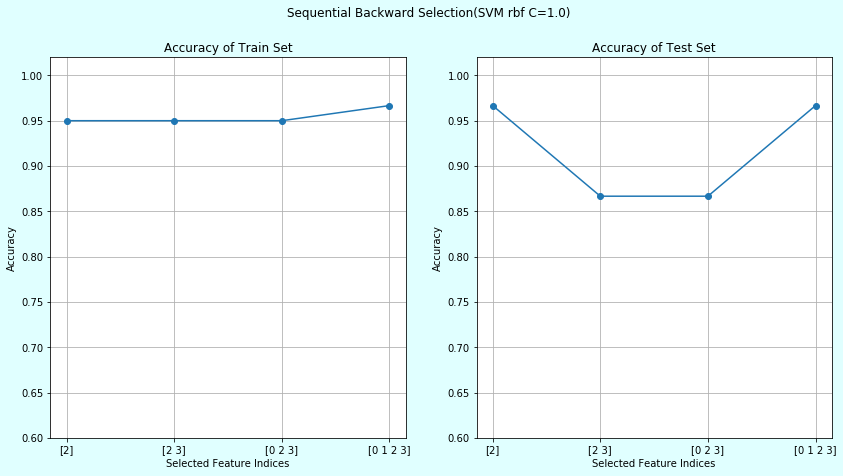

In [72]:
# Performance
result_train = []
result_test = []

eta = 0.01
batch_size = 4

for sub in fs1.subsets_:
    clf = SVC(kernel='rbf', C=1.0, random_state=1)
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Sequential Backward Selection(SVM rbf C=1.0)')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.6, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.6, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

- Logistic 보다는 결과가 괜찮게 나왔다.

#### 3-2-2.  feature_importances_ Method

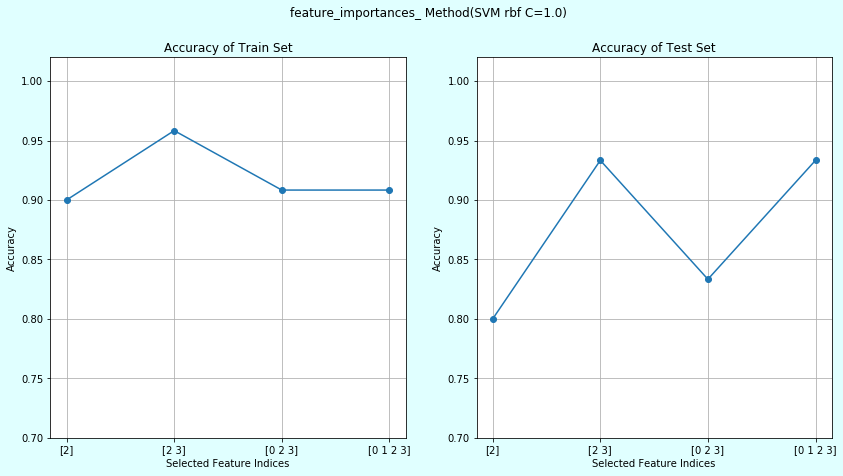

In [73]:
# Performance
result_train = []
result_test = []

eta = 0.01
batch_size = 4

for sub in subset:
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('feature_importances_ Method(SVM rbf C=1.0)')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.7, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.7, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

#### Result
- 역시 Random Forest처럼 높은 정확도가 나오지는 않았으나 Logistic model에 비해서는 비교적 높은 정확도가 나왔다.

### 3-3. KKN

#### 3-3-1. SBS

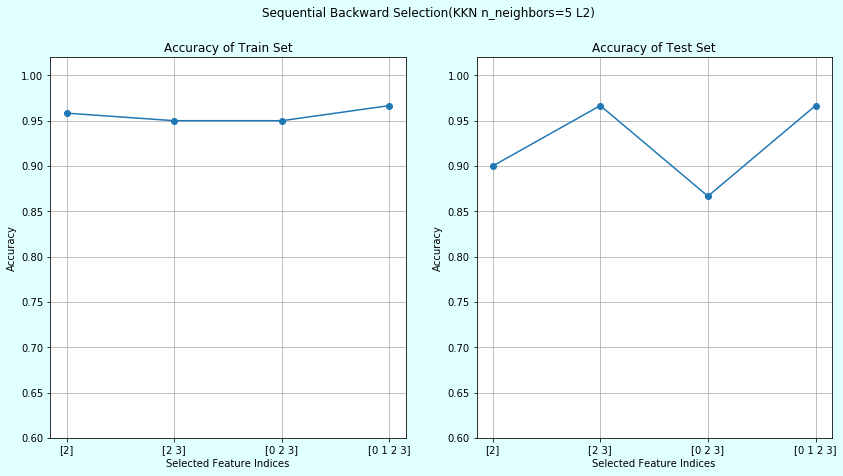

In [74]:
# Performance
result_train = []
result_test = []

eta = 0.01
batch_size = 4

for sub in fs1.subsets_:
    clf = KNeighborsClassifier(n_neighbors=5,p=2,metric='minkowski')
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('Sequential Backward Selection(KKN n_neighbors=5 L2)')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.6, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.6, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

- KNN 방식에서는 SBS에서 결정한 feature subset에서 더 좋은 결과나 나왔다.

#### 3-3-2.  feature_importances_ Method

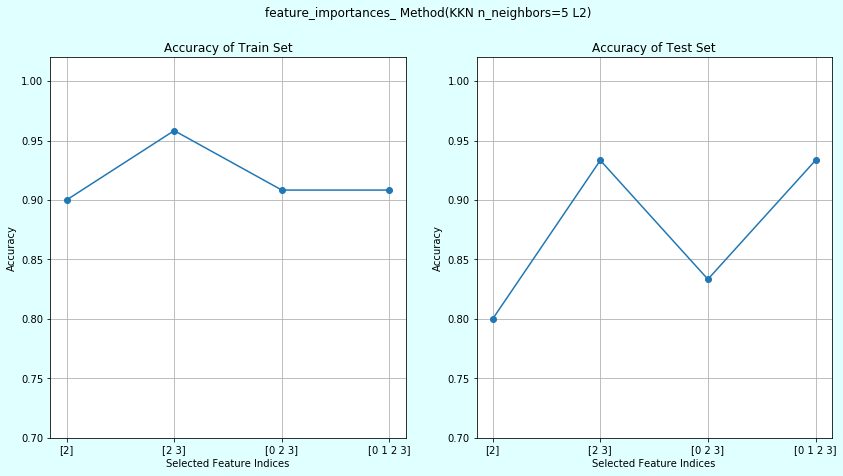

In [75]:
# Performance
result_train = []
result_test = []

eta = 0.01
batch_size = 4

for sub in subset:
    clf = LogisticRegressionGD_3C(random_state=1, eta=eta, n_iter=50, batch_size=batch_size)
    clf.fit(X_train_std[:,sub],y_train)
    result_train.append(accuracy_score(y_train,clf.predict(X_train_std[:,sub])))
    result_test.append(accuracy_score(y_test, clf.predict(X_test_std[:, sub])))


fig = plt.figure(figsize=(14,7))
fig.patch.set_facecolor('lightcyan')
fig.suptitle('feature_importances_ Method(KKN n_neighbors=5 L2)')

ax = fig.subplots(1,2)
ax[0].set_title('Accuracy of Train Set')
ax[0].plot(k_feat, result_train, marker='o')
ax[0].set_ylim(0.7, 1.02)
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Selected Feature Indices')
ax[0].set_xticks(k_feat)
ax[0].set_xticklabels(subset)
ax[0].grid()

ax[1].set_title('Accuracy of Test Set')
ax[1].plot(k_feat, result_test, marker='o')
ax[1].set_ylim(0.7, 1.02)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Selected Feature Indices')
ax[1].set_xticks(k_feat)
ax[1].set_xticklabels(subset)
ax[1].grid()

#### Result
- 앞서 Random forest, Logistic, SVM 모두 feature_importance_ 값을 기준으로 나눈 subset 들에 대해서 그나마 선형적인 데이터가 나오고 performance도 좋았다.
- 하지만 KNN의 경우는 SBS 방식으로 나눈 subset들에 대해서 더 좋은 결과가 나왔다.